# 予定
1. アクチュエータへの入力で一旦SB3で学習してみる
2. 逆運動学を利用して、エンドエフェクタの位置あるいは速度などで制御できるようにする
    - 実機でもしっかり取得できる情報じゃないと困る
    - ROS2でも同じ方法を使う必要がある


In [1]:
%matplotlib inline
import os
import mujoco
import numpy as np
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.spaces import Box
from typing import Dict, Union
import matplotlib.pyplot as plt
import cv2



DEFAULT_CAMERA_CONFIG = {
    "trackbodyid": -1,
    "distance": 4.0,
}

class MyRobotEnv(MujocoEnv):
    def __init__(
        self, 
        xml_path = "/workspace/ros2_ws/src/airhockey2025/ka/assets/main.xml",
        frame_skip: int = 5,
        default_camera_config: Dict[str, Union[float, int]] = DEFAULT_CAMERA_CONFIG,
        **kwargs,
    ):
        # 一度モデルを読み込んで観測次元を取得
        model = mujoco.MjModel.from_xml_path(xml_path)
        obs_dim = model.nq + model.nv
        observation_space = Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # 行動空間：joint velocities [-1, 1] 正規化
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=model.actuator_actnum.shape, dtype=np.float32
        )
        
        # 親クラスの初期化
        super().__init__(
            model_path=xml_path,
            frame_skip=frame_skip,
            observation_space=observation_space,
            render_mode="rgb_array",
            default_camera_config=default_camera_config,
            **kwargs,
        )
        
        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
                "rgbd_tuple",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }
        self.configure_puck()

    def step(self, action):
        # 正規化されたactionをスケーリング
        scaled_action = action * self.model.actuator_ctrlrange[:, 1]
        self.do_simulation(scaled_action, self.frame_skip)

        obs = self._get_obs()
        reward = self._compute_reward(obs, action)
        done = self._is_done()
        info = {}

        return obs, reward, done, info
    
    def _is_done(self):
        x = self.data.qpos[self.puck_x_id]
        if not self.puck_x_range.min() < x < self.puck_x_range.max():
            return True
        return False


    def _get_obs(self):
        return np.concatenate([self.data.qpos.flat, self.data.qvel.flat])

    def _compute_reward(self, obs, action):
        # エンドエフェクタの位置を使用した報酬例
        site_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_SITE, "ee_site")
        end_effector_pos = self.data.site_xpos[site_id]
        goal = np.array([0.5, 0.0, 0.2])
        dist = np.linalg.norm(end_effector_pos - goal)
        return -dist

    def reset_model(self):
        # ランダム初期化
        qpos = self.init_qpos + np.random.uniform(-0.1, 0.1, size=self.model.nq)
        qvel = self.init_qvel + np.random.uniform(-0.1, 0.1, size=self.model.nv)

        # パック初期化
        # theta = np.random.uniform(0, 2 * np.pi)
        theta = 0
        qpos[self.puck_x_id] = np.random.uniform(*self.puck_x_range)
        qpos[self.puck_y_id] = 0 # np.random.uniform(*self.puck_y_range)
        qvel[self.puck_x_id] = self.puck_speed * np.cos(theta)
        qvel[self.puck_y_id] = self.puck_speed * np.sin(theta)

        self.set_state(qpos, qvel)
        return self._get_obs()
    
    def configure_puck(self):
        self.puck_speed = 10.0
        self.puck_x_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_JOINT, "puck_x")
        self.puck_y_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_JOINT, "puck_y")

        self.table_surface_id = mujoco.mj_name2id(self.model, mujoco.mjtObj.mjOBJ_BODY, "table_surface")
        geom_indices = [j for j in range(self.model.ngeom) if self.model.geom_bodyid[j] == self.table_surface_id]
        assert len(geom_indices) == 1
        x, y, _ = self.model.geom_size[geom_indices[0]]
        self.puck_x_range = np.array([-x, x]) * 0.8
        self.puck_y_range = np.array([-y, y]) * 0.8
    




        

# register(
#     id='ArmHockey-v0',
#     entry_point='myenv.env:MyEnv'
# )

In [2]:
def render(images):
    for img in images:
        # 画像をuint8のBGRに変換（OpenCV用）
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('Video', img_bgr)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

In [3]:
env = MyRobotEnv()
env.reset()
images = []
skip_frame = 5
observations = []
dones = []

for i in range(500):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    observations.append(obs)
    if i % skip_frame == 0:
        images.append(env.render())

render(images)

: 

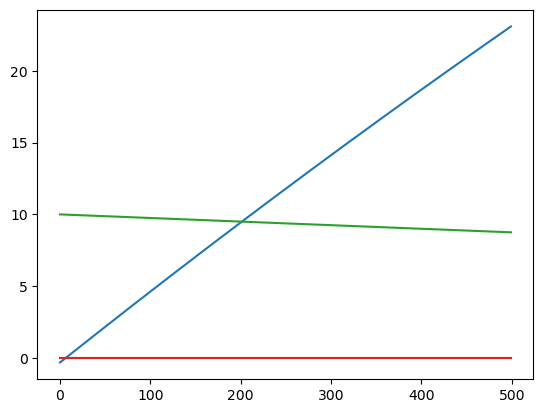

In [28]:
# パックの動きの可視化: 上がqpos、下がqvel
plt.plot(np.array(observations)[:, env.puck_x_id])
plt.plot(np.array(observations)[:, env.puck_y_id])
plt.plot(np.array(observations)[:, env.puck_x_id + env.model.njnt])
plt.plot(np.array(observations)[:, env.puck_y_id + env.model.njnt])

In [54]:
def print_joint(model):
    for i in range(model.njnt):
        name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i)
        addr = model.jnt_qposadr[i]
        dof = model.jnt_dofadr[i]
        type_ = model.jnt_type[i]
        print(f"Joint {i}: name={name}, qpos address={addr}, dof address={dof}, type={type_}")

def print_body(model):
    # ボディ情報へのアクセス
    for i in range(model.nbody):
        # ボディ名の取得
        body_name = model.body(i).name
        
        # ボディの位置(3次元ベクトル)
        body_pos = model.body_pos[i]
        
        # ボディの方向(クォータニオン)
        body_quat = model.body_quat[i]
        
        # ボディに関連するgeomの情報を取得
        geom_indices = [j for j in range(model.ngeom) if model.geom_bodyid[j] == i]
        
        for geom_idx in geom_indices:
            # geomの種類
            geom_type = model.geom_type[geom_idx]
            
            # geomの寸法 (種類によって意味が異なる)
            geom_size = model.geom_size[geom_idx]
            
            # geomの種類に応じて寸法を解釈
            if geom_type == mujoco.mjtGeom.mjGEOM_BOX:
                # BOXの場合、半辺長x, y, z
                x, y, z = geom_size
                print(f"Body {i}: {body_name}, Box geom {geom_idx}: {model.geom(geom_idx).name}, Size: {x*2}x{y*2}x{z*2}")
            
            elif geom_type == mujoco.mjtGeom.mjGEOM_SPHERE:
                # 球の場合、半径
                radius = geom_size[0]
                print(f"Body {i}: {body_name}, Sphere geom {geom_idx}: {model.geom(geom_idx).name}, Radius: {radius}")
            
            elif geom_type == mujoco.mjtGeom.mjGEOM_CYLINDER:
                # 円柱の場合、半径と高さの半分
                radius = geom_size
                print(f"Body {i}: {body_name}, Cylinder geom {geom_idx}: {model.geom(geom_idx).name}, Radius: {radius}")
        
        print(f"Body {i}: {body_name}, Position: {body_pos}, Quaternion: {body_quat}")



In [22]:
env.model.names.decode('utf-8').split("\x00")

['air_hockey_robot_env',
 'world',
 'table',
 'table_surface',
 'rim',
 'base',
 'puck',
 'root',
 'crane_x7_shoulder_revolute_part_link',
 'crane_x7_upper_arm_fixed_part_link',
 'crane_x7_upper_arm_revolute_part_link',
 'crane_x7_lower_arm_fixed_part_link',
 'crane_x7_lower_arm_revolute_part_link',
 'crane_x7_wrist_link',
 'crane_x7_gripper_base_link',
 'crane_x7_gripper_finger_a_link',
 'crane_x7_gripper_finger_b_link',
 'racket',
 'puck_x',
 'puck_y',
 'puck_yaw',
 'crane_x7_shoulder_fixed_part_pan_joint',
 'crane_x7_shoulder_revolute_part_tilt_joint',
 'crane_x7_upper_arm_revolute_part_twist_joint',
 'crane_x7_upper_arm_revolute_part_rotate_joint',
 'crane_x7_lower_arm_fixed_part_joint',
 'crane_x7_lower_arm_revolute_part_joint',
 'crane_x7_wrist_joint',
 'crane_x7_gripper_finger_a_joint',
 'crane_x7_gripper_finger_b_joint',
 'floor',
 'surface',
 'rim_home_l',
 'rim_home_r',
 'rim_home_top',
 'rim_left',
 'rim_right',
 'rim_away_l',
 'rim_away_r',
 'rim_away_top',
 'puck',
 '',
 '

In [61]:
import pickle
import numpy as np

with open("../observations.pkl", "rb") as f:
    observations = np.array(pickle.load(f)).squeeze(1)

In [57]:
print_joint(env.model)

Joint 0: name=puck_x, qpos address=0, dof address=0, type=2
Joint 1: name=puck_y, qpos address=1, dof address=1, type=2
Joint 2: name=puck_yaw, qpos address=2, dof address=2, type=3
Joint 3: name=crane_x7_shoulder_fixed_part_pan_joint, qpos address=3, dof address=3, type=3
Joint 4: name=crane_x7_shoulder_revolute_part_tilt_joint, qpos address=4, dof address=4, type=3
Joint 5: name=crane_x7_upper_arm_revolute_part_twist_joint, qpos address=5, dof address=5, type=3
Joint 6: name=crane_x7_upper_arm_revolute_part_rotate_joint, qpos address=6, dof address=6, type=3
Joint 7: name=crane_x7_lower_arm_fixed_part_joint, qpos address=7, dof address=7, type=3
Joint 8: name=crane_x7_lower_arm_revolute_part_joint, qpos address=8, dof address=8, type=3
Joint 9: name=crane_x7_wrist_joint, qpos address=9, dof address=9, type=3
Joint 10: name=crane_x7_gripper_finger_a_joint, qpos address=10, dof address=10, type=3
Joint 11: name=crane_x7_gripper_finger_b_joint, qpos address=11, dof address=11, type=3


In [71]:
# 全ジョイントの名前とrangeを表示
model = env.model
print("All joint ranges:")
for i in range(model.njnt):
    name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i)
    jrange = model.jnt_range[i]  # (min, max)
    jtype = model.jnt_type[i]
    print(f"Joint {i}: {name}, Type: {jtype}, Range: [{jrange[0]:.3f}, {jrange[1]:.3f}]")


All joint ranges:
Joint 0: puck_x, Type: 2, Range: [0.000, 0.000]
Joint 1: puck_y, Type: 2, Range: [0.000, 0.000]
Joint 2: puck_yaw, Type: 3, Range: [0.000, 0.000]
Joint 3: crane_x7_shoulder_fixed_part_pan_joint, Type: 3, Range: [-2.740, 2.740]
Joint 4: crane_x7_shoulder_revolute_part_tilt_joint, Type: 3, Range: [-1.606, 1.606]
Joint 5: crane_x7_upper_arm_revolute_part_twist_joint, Type: 3, Range: [-2.740, 2.740]
Joint 6: crane_x7_upper_arm_revolute_part_rotate_joint, Type: 3, Range: [-2.810, 0.000]
Joint 7: crane_x7_lower_arm_fixed_part_joint, Type: 3, Range: [-2.740, 2.740]
Joint 8: crane_x7_lower_arm_revolute_part_joint, Type: 3, Range: [-1.571, 1.571]
Joint 9: crane_x7_wrist_joint, Type: 3, Range: [-2.915, 2.915]
Joint 10: crane_x7_gripper_finger_a_joint, Type: 3, Range: [-0.087, 1.571]
Joint 11: crane_x7_gripper_finger_b_joint, Type: 3, Range: [-0.087, 1.571]


(array([18075.,  3356.,   380.,   410.,   417.,   450.,   476.,   463.,
          531.,   554.,   511.,   617.,   764.,   987., 20327.,  3821.,
         3022.,  3099.,  3510.,  8444., 11492.,  4370.,   324.,   292.,
          263.,   246.,   221.,   208.,   191., 12179.]),
 array([-1.62488895, -1.51541701, -1.40594506, -1.29647312, -1.18700117,
        -1.07752923, -0.96805729, -0.85858534, -0.7491134 , -0.63964146,
        -0.53016951, -0.42069757, -0.31122563, -0.20175368, -0.09228174,
         0.0171902 ,  0.12666215,  0.23613409,  0.34560603,  0.45507798,
         0.56454992,  0.67402187,  0.78349381,  0.89296575,  1.0024377 ,
         1.11190964,  1.22138158,  1.33085353,  1.44032547,  1.54979741,
         1.65926936]),
 <a list of 30 Patch objects>)

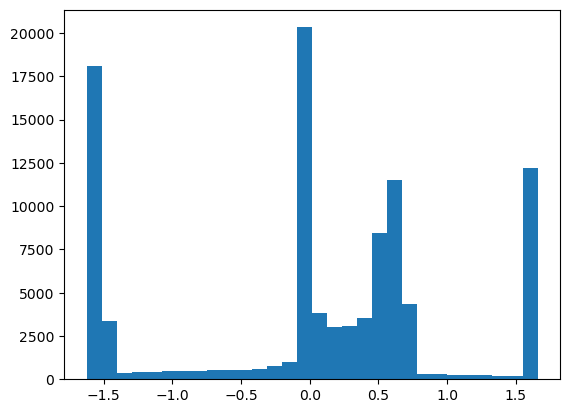

In [67]:
n = 4
plt.hist(observations[:, n], bins=30)